# Message Passing

Let $\textbf{h}_v^{(0)} = \textbf{x}_v$ be the feature for node $v$, and $\textbf{e}_{u,v}$ be the feature for edge $(u,v)$.

The message passing paradigm defines the following node-wise and edge-wise computation at the next graph neural net (GNN) layer

Edge-Wise: 
$\textbf{m}_{u,v}^{(l+1)} = ϕ(\textbf{h}_v^{(l)}, \textbf{h}_u^{(l)}, \textbf{e}_{u,v})$

Node-Wise:
$\textbf{h}_{v}^{(l+1)} = ψ(\textbf{h}_v^{(l)}, ρ(\{\textbf{m}_{u,v}^{(l+1)}\ ∀ u ∈ \mathcal{N}(v)\})$

In the above equations, $ϕ$ is a message function defined on each edge to generate a message by combining the edge feature with the features of its incident nodes, $u ∈  \mathcal{N}(v)$; $ψ$ is an update function defined on each node to update the node feature by aggregating its incoming messages using the reduce function $ρ$.

In DGL, message function takes a single argument edges, which is an EdgeBatch instance. During message passing, DGL generates it internally to represent a batch of edges. It has three members src, dst and data to access features of source nodes, destination nodes, and edges, respectively.

reduce function takes a single argument nodes, which is a NodeBatch instance. During message passing, DGL generates it internally to represent a batch of nodes. It has member mailbox to access the messages received for the nodes in the batch. Some of the most common reduce operations include sum, max, min, etc.

update function takes a single argument nodes as described above. This function operates on the aggregation result from reduce function, typically combining it with a node’s original feature at the the last step and saving the result as a node feature.

DGL has implemented commonly used message functions and reduce functions as built-in in the namespace dgl.function. In general, DGL suggests using built-in functions whenever possible since they are heavily optimized and automatically handle dimension broadcasting.

If your message passing functions cannot be implemented with built-ins, you can implement user-defined message/reduce function (aka. UDF).

Built-in message functions can be unary or binary. DGL supports copy for unary. For binary funcs, DGL supports add, sub, mul, div, dot. The naming convention for message built-in funcs is that u represents src nodes, v represents dst nodes, and e represents edges. The parameters for those functions are strings indicating the input and output field names for the corresponding nodes and edges. The list of supported built-in functions can be found in DGL Built-in Function. For example, to add the hu feature from src nodes and hv feature from dst nodes then save the result on the edge at he field, one can use built-in function dgl.function.u_add_v('hu', 'hv', 'he'). This is equivalent to the Message UDF:

In [1]:
import numpy as np

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl.nn import SAGEConv

import networkx as nx

import matplotlib.pyplot as plt

import dgl.function as fn

torch.manual_seed(0)

In [2]:
# Instantiate a graph and set a node feature 'h'.
u = torch.tensor([0,0,2,0])
v = torch.tensor([1,2,3,3])
g = dgl.graph((u, v))
g.ndata['h'] = torch.tensor([[1, 0],
                             [1, 0],
                             [1, 0],
                             [1, 0]])
#torch.ones(2, 1)

In [3]:
x = g.ndata
x

{'h': tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])}

In [4]:
g.edata

{}

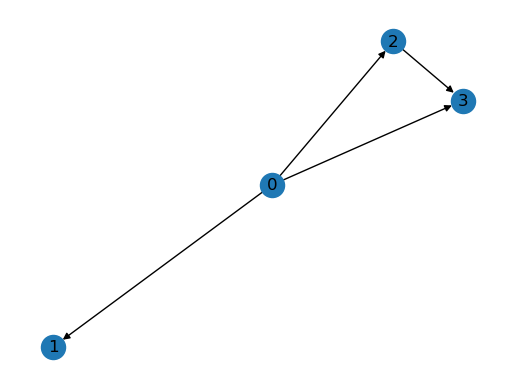

In [5]:
plt.figure(1)
plt.subplot(111)
nx.draw(g.to_networkx(), with_labels=True)

Messages are passed along the edges from node to node.

The message function is in general from node $u$ to $v$ is:

$\textbf{m}_{u,v}=ϕ(\textbf{h}_v,\textbf{h}_u,\textbf{e}_{u,v})$

# Message Function

In DGL, **message function** takes a single argument edges, which is an EdgeBatch instance. During message passing, DGL generates it internally to represent a batch of edges. It has three members src, dst and data to access features of source nodes, destination nodes, and edges, respectively.

A simple **message function** is to return the source node feature, this can be stored in edge with the feature label `m` for message

This can be written below:

In [6]:
def message_func(edges):
    # edges.src['h'] is a tensor of shape (E, 1),
    # where E is the number of edges in the batch.
    return {'m': edges.src['h']}

`edges.src` calls source node $u$.

`edges.src['h']` calls the $\textbf{h}_u$ feature of the source node $u$.

# Aggregation (or Reduce) Function

For messages to be passed to a destination node, the multiple messages from different source nodes may need to be aggregated with an **aggregate** or **reduce function** 

reduce function takes a single argument nodes, which is a NodeBatch instance. During message passing, DGL generates it internally to represent a batch of nodes. It has member mailbox to access the messages received for the nodes in the batch. Some of the most common reduce operations include sum, max, min, etc.

DGL has implemented commonly used message functions and reduce functions as built-in in the namespace dgl.function. In general, DGL suggests using built-in functions whenever possible since they are heavily optimized and automatically handle dimension broadcasting.

A sum aggregation can be written as

In [7]:
def reduce_func(nodes):
     return {'h': torch.sum(nodes.mailbox['m'], dim=1)}

or `dgl.function.sum('m', 'h')`

Built-in reduce functions support operations sum, max, min, and mean. Reduce functions usually have two parameters, one for field name in mailbox, one for field name in node features, both are strings. For example, dgl.function.sum('m', 'h') is equivalent to the Reduce UDF that sums up the message m:

`def reduce_func(nodes): 
     return {'h': torch.sum(nodes.mailbox['m'], dim=1)
`}

# Passing the Messages

The messages from source nodes $u$ can now be passed and aggregated to the destination nodes $v$ using the `update_all` function.

`DGLGraph.update_all(message_func, reduce_func, apply_node_func=None, etype=None)`

Send messages along all the edges of the specified type and update all the nodes of the corresponding destination type.

For heterogeneous graphs with number of relation types > 1, send messages along all the edges, reduce them by type-wisely and across different types at the same time. Then, update the node features of all the nodes.

Parameters
message_func (dgl.function.BuiltinFunction or callable) – The message function to generate messages along the edges. It must be either a DGL Built-in Function or a User-defined Functions.

reduce_func (dgl.function.BuiltinFunction or callable) – The reduce function to aggregate the messages. It must be either a DGL Built-in Function or a User-defined Functions.

apply_node_func (callable, optional) – An optional apply function to further update the node features after the message reduction. It must be a User-defined Functions.

etype (str or (str, str, str), optional) –

The type name of the edges. The allowed type name formats are:

(str, str, str) for source node type, edge type and destination node type.

or one str edge type name if the name can uniquely identify a triplet format in the graph.

Can be omitted if the graph has only one type of edges.

For now we'll ignore the apply_node_func function for now.m

In [8]:
g.update_all(message_func, reduce_func)

The original node features are $\textbf{h}_v^{0} = \textbf{x}_v$

And after the first round, or layer, of message passing and aggregation the node features are updated to $\textbf{z}_v = \textbf{h}_v^{1}$

In [9]:
z = g.ndata['h']
z

tensor([[0, 0],
        [1, 0],
        [1, 0],
        [2, 0]])

Oftentimes, the new aggregated node features will go through one final function referred to as an **update function**.

This function could be something like an activation ($\textrm{Sigmoid}(.)$, $\textrm{ReLU}(.)$, etc.) and/or a combination or concatentation with the original node features. Afterall, note that for node $u=0$ its aggregated features are all null because there are no messages passing to this node.

This final update function *could* be applied within the above `update_all` function, but DGL recommends against this. Instead, they suggest apply the *update function* explicitly after using DGL's `update_all` function. Terminology wise, this can get confusing. 

But remember, it's best to apply the **message** and **reduce** functions using DGL's `update_all` function. Then any final **update**, such as an activation or concatenation, you wish to do the aggregated results should be done afterwards.

In [10]:
def custom_update(graph):
    g.update_all(message_func, reduce_func)
    
    # Call update function outside of update_all
    final_h = torch.sigmoid(torch.tensor(graph.ndata['h']))
    return final_h

In [11]:
u = torch.tensor([0,0,2,0])
v = torch.tensor([1,2,3,3])
g = dgl.graph((u, v))
g.ndata['h'] = torch.tensor([[1, 0],
                             [1, 0],
                             [1, 0],
                             [1, 0]])

x = g.ndata['h']
x

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])

In [12]:
z = custom_update(g)
z

C:\Users\Alex\AppData\Local\Temp\ipykernel_17728\2933635481.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_h = torch.sigmoid(torch.tensor(graph.ndata['h']))


tensor([[0.5000, 0.5000],
        [0.7311, 0.5000],
        [0.7311, 0.5000],
        [0.8808, 0.5000]])

Now, we see that the $\textrm{Sigmoid}$ function has been applied to our previous $\textbf{z}_v = \textbf{h}_v^{1}$ values using our `custom_update` function.

## Applying only edge-wise computations

It is also possible to invoke only edge-wise computation by apply_edges() without invoking message passing. apply_edges() takes a message function for parameter and by default updates the features of all edges. For example:

These `src` features can be applied to the edges with the `applied_edges` function

In [13]:
# Copy features from source nodes to edges.
#g_.apply_edges(edge_copy_src)

# A Simple Message Passing Example

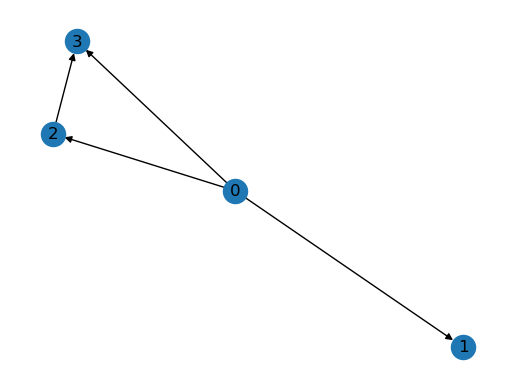

In [14]:
# Instantiate a graph and set a node feature 'h'.
u = torch.tensor([0,0,2,0])
v = torch.tensor([1,2,3,3])
g = dgl.graph((u, v))
g.ndata['h'] = torch.tensor([[1, 0],
                             [0, 0],
                             [0, 0],
                             [0, 0]], dtype=torch.float32)

g.ndata['i'] = torch.tensor([0,1,2,3])


plt.figure(1)
plt.subplot(111)
nx.draw(g.to_networkx(), with_labels=True)

In [15]:
def message_func(edges):

    h0 = edges.src['h']
    m1 = h0 
    print('EdgeBatch properties')
    print('m = h')
    print()
    
    return {'m': m1}

def aggregate_func(nodes):

    print('NodeBatch properties')
    print(f"Dst nodes : {nodes.data['i']}")
    print()
    print(f"Messages from src nodes : {nodes.mailbox}")
    print()
    print(f"Dst node data : {nodes.data}")
    print()
    print('Average incoming messages: h1 = Mean(m)')

    h1 = torch.mean(nodes.mailbox['m'], dim=1)

    print({'h1': h1})
    print()
    print('---')

    return {'h1': h1}

In [16]:
g.update_all(message_func, aggregate_func)

EdgeBatch properties
m = h

NodeBatch properties
Dst nodes : tensor([1, 2])

Messages from src nodes : {'m': tensor([[[1., 0.]],

        [[1., 0.]]])}

Dst node data : {'h': tensor([[0., 0.],
        [0., 0.]]), 'i': tensor([1, 2])}

Average incoming messages: h1 = Mean(m)
{'h1': tensor([[1., 0.],
        [1., 0.]])}

---
NodeBatch properties
Dst nodes : tensor([3])

Messages from src nodes : {'m': tensor([[[0., 0.],
         [1., 0.]]])}

Dst node data : {'h': tensor([[0., 0.]]), 'i': tensor([3])}

Average incoming messages: h1 = Mean(m)
{'h1': tensor([[0.5000, 0.0000]])}

---


In [17]:
g.ndata['h']

tensor([[1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [18]:
g.ndata['h1']

tensor([[0.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [0.5000, 0.0000]])

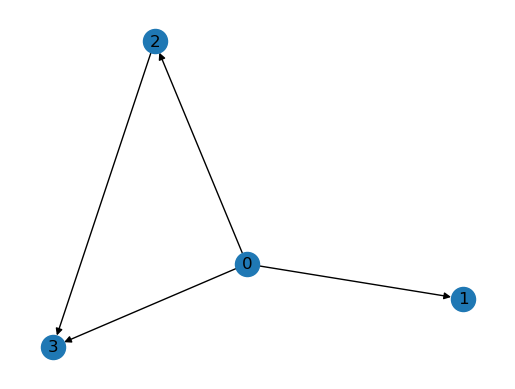

In [19]:
plt.figure(1)
plt.subplot(111)
nx.draw(g.to_networkx(), with_labels=True)

# An example with linear layers

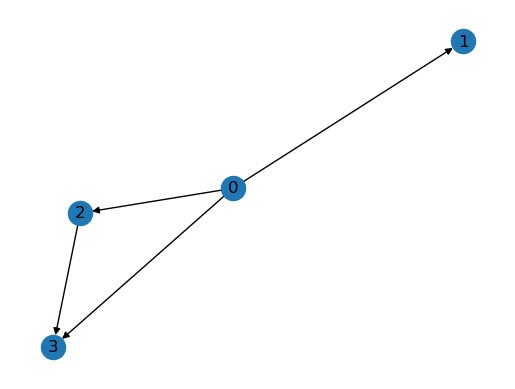

In [20]:
# Instantiate a graph and set a node feature 'h'.
u = torch.tensor([0,0,2,0])
v = torch.tensor([1,2,3,3])
g = dgl.graph((u, v))
g.ndata['h'] = torch.tensor([[1, 0],
                             [0, 0],
                             [0, 0],
                             [0, 0]], dtype=torch.float32)

g.ndata['i'] = torch.tensor([0,1,2,3])


plt.figure(1)
plt.subplot(111)
nx.draw(g.to_networkx(), with_labels=True)

In [21]:
MLP = nn.Linear(2,2)

In [22]:
def message_func(edges):

    h0 = edges.src['h']
    m1 = MLP(h0) 
    print('EdgeBatch properties')
    print(f'Src node features : {h0}')
    print()
    print('Messages calculated from src features using a linear layer: m = W(h)')
    print({'m': m1})
    print()
    print('---')
    
    return {'m': m1}

def aggregate_func(nodes):

    print('NodeBatch properties')
    print(f"Dst nodes : {nodes.data['i']}")
    print()
    print(f"Messages from src nodes : {nodes.mailbox}")
    print()
    print(f"Dst node data : {nodes.data}")
    print()
    print('Average incoming messages: h1 = Mean(m)')

    h1 = torch.mean(nodes.mailbox['m'], dim=1)

    print({'h1': h1})
    print()
    print('------')

    return {'h1': h1}

In [23]:
g.update_all(message_func, aggregate_func)

EdgeBatch properties
Src node features : tensor([[1., 0.],
        [1., 0.],
        [0., 0.],
        [1., 0.]])

Messages calculated from src features using a linear layer: m = W(h)
{'m': tensor([[-0.2776, -0.3924],
        [-0.2776, -0.3924],
        [-0.2723,  0.1896],
        [-0.2776, -0.3924]], grad_fn=<AddmmBackward0>)}

---
NodeBatch properties
Dst nodes : tensor([1, 2])

Messages from src nodes : {'m': tensor([[[-0.2776, -0.3924]],

        [[-0.2776, -0.3924]]], grad_fn=<ReshapeAliasBackward0>)}

Dst node data : {'h': tensor([[0., 0.],
        [0., 0.]]), 'i': tensor([1, 2])}

Average incoming messages: h1 = Mean(m)
{'h1': tensor([[-0.2776, -0.3924],
        [-0.2776, -0.3924]], grad_fn=<MeanBackward1>)}

------
NodeBatch properties
Dst nodes : tensor([3])

Messages from src nodes : {'m': tensor([[[-0.2723,  0.1896],
         [-0.2776, -0.3924]]], grad_fn=<ReshapeAliasBackward0>)}

Dst node data : {'h': tensor([[0., 0.]]), 'i': tensor([3])}

Average incoming messages: h1 = M

In [24]:
g.ndata['h']

tensor([[1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [25]:
g.ndata['h1']

tensor([[ 0.0000,  0.0000],
        [-0.2776, -0.3924],
        [-0.2776, -0.3924],
        [-0.2750, -0.1014]], grad_fn=<IndexCopyBackward0>)

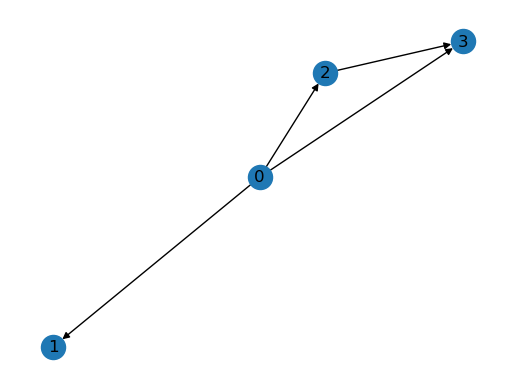

In [26]:
plt.figure(1)
plt.subplot(111)
nx.draw(g.to_networkx(), with_labels=True)